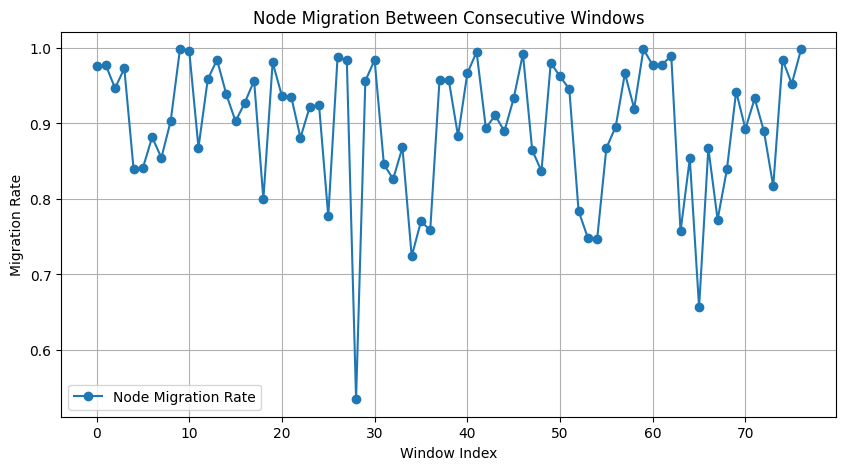

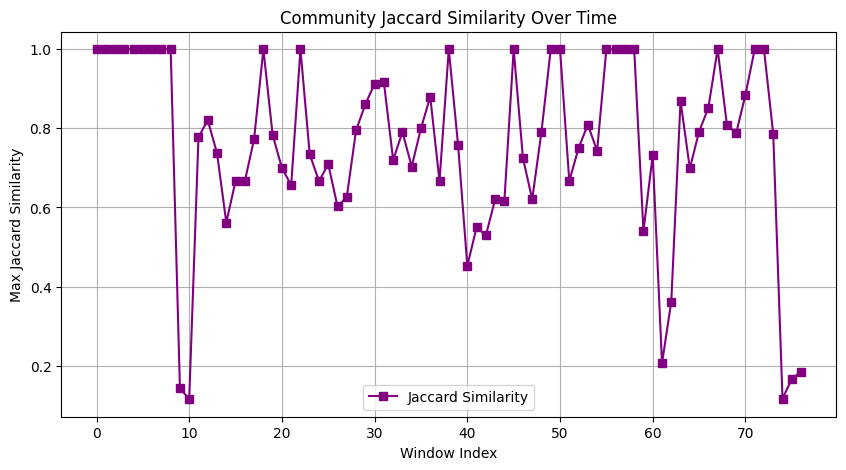

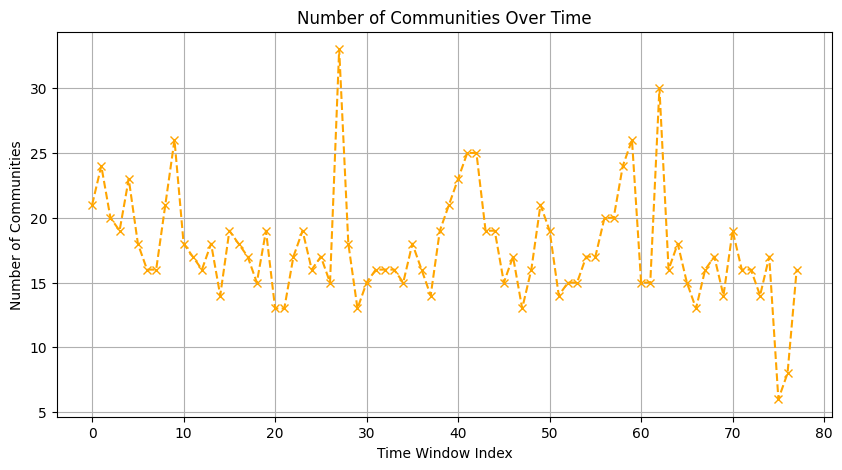

In [32]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from cdlib import algorithms, TemporalClustering
from sklearn.metrics import jaccard_score
from collections import defaultdict
import os
import seaborn as sns
import numpy as np

# --- Helper to convert communities to node → community_id mapping ---
def node_to_community_map(communities):
    mapping = {}
    for cid, community in enumerate(communities):
        for node in community:
            mapping[node] = cid
    return mapping

# --- Compute node migration rates ---
def compute_node_migration(clusterings):
    migrations = []
    for i in range(len(clusterings) - 1):
        c1_map = node_to_community_map(clusterings[i].communities)
        c2_map = node_to_community_map(clusterings[i + 1].communities)

        nodes = set(c1_map.keys()).union(c2_map.keys())
        changed = sum(1 for n in nodes if c1_map.get(n) != c2_map.get(n))
        rate = changed / len(nodes) if nodes else 0
        migrations.append(rate)
    return migrations

# --- Compute Jaccard similarities between communities across windows ---
def compute_jaccard_similarity(clusterings):
    similarities = []
    for i in range(len(clusterings) - 1):
        comms1 = [set(c) for c in clusterings[i].communities]
        comms2 = [set(c) for c in clusterings[i + 1].communities]

        best_sim = 0
        for c1 in comms1:
            for c2 in comms2:
                intersection = len(c1 & c2)
                union = len(c1 | c2)
                if union > 0:
                    sim = intersection / union
                    best_sim = max(best_sim, sim)
        similarities.append(best_sim)
    return similarities


# --- Load and preprocess data ---
df = pd.read_csv('../data/email-Eu-core-temporal.txt', sep=' ', names=['source', 'target', 'timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# --- Define time window parameters ---
window_size = pd.Timedelta(days=7)
start_time = df['timestamp'].min()
end_time = df['timestamp'].max()

time_windows = []
current_time = start_time
while current_time < end_time:
    time_windows.append((current_time, current_time + window_size))
    current_time += window_size

# --- Community detection per window ---
tc = TemporalClustering()
graphs = []

for idx, (start, end) in enumerate(time_windows):
    window_df = df[(df['timestamp'] >= start) & (df['timestamp'] < end)]
    if window_df.empty:
        continue

    G = nx.from_pandas_edgelist(window_df, 'source', 'target', create_using=nx.DiGraph())
    undirected_G = G.to_undirected()
    coms = algorithms.louvain(undirected_G)
    
    graphs.append(G)
    tc.add_clustering(coms, start.timestamp())  # or just use `start` if you prefer


# --- Compute node migration rates ---
def compute_node_migration(clusterings):
    migrations = []
    for i in range(len(clusterings) - 1):
        c1 = node_to_community_map(clusterings[i].communities)
        c2 = node_to_community_map(clusterings[i + 1].communities)
        
        nodes = set(c1.keys()).union(c2.keys())
        changed = sum(1 for n in nodes if c1.get(n) != c2.get(n))
        rate = changed / len(nodes) if nodes else 0
        migrations.append(rate)
    return migrations

# --- Compute community Jaccard similarities between windows ---
def compute_jaccard_similarity(clusterings):
    similarities = []
    for i in range(len(clusterings) - 1):
        comms1 = [set(c) for c in clusterings[i].communities]
        comms2 = [set(c) for c in clusterings[i+1].communities]

        best_sim = 0
        for c1 in comms1:
            for c2 in comms2:
                intersection = len(c1 & c2)
                union = len(c1 | c2)
                if union > 0:
                    sim = intersection / union
                    if sim > best_sim:
                        best_sim = sim
        similarities.append(best_sim)
    return similarities

# --- Plot metrics ---
if len(tc.clusterings) >= 2:
    migration_rates = compute_node_migration(tc.clusterings)
    jaccard_similarities = compute_jaccard_similarity(tc.clusterings)

    # Plot node migration
    plt.figure(figsize=(10, 5))
    plt.plot(migration_rates, marker='o', label='Node Migration Rate')
    plt.title('Node Migration Between Consecutive Windows')
    plt.xlabel('Window Index')
    plt.ylabel('Migration Rate')
    plt.grid(True)
    plt.legend()
    plt.savefig('node_migration_email_eu_core.png')
    plt.show()

    # Plot Jaccard similarity
    plt.figure(figsize=(10, 5))
    plt.plot(jaccard_similarities, marker='s', color='purple', label='Jaccard Similarity')
    plt.title('Community Jaccard Similarity Over Time')
    plt.xlabel('Window Index')
    plt.ylabel('Max Jaccard Similarity')
    plt.grid(True)
    plt.legend()
    plt.savefig('jaccard_similarity_email_eu_core.png')
    plt.show()
else:
    print("Not enough clusterings to evaluate temporal metrics.")

# --- Plot number of communities over time ---
num_communities = [len(clustering.communities) for clustering in tc.clusterings.values()]

plt.figure(figsize=(10, 5))
plt.plot(num_communities, marker='x', linestyle='--', color='orange')
plt.title('Number of Communities Over Time')
plt.xlabel('Time Window Index')
plt.ylabel('Number of Communities')
plt.grid(True)
plt.savefig('num_communities_email_eu_core.png')
plt.show()

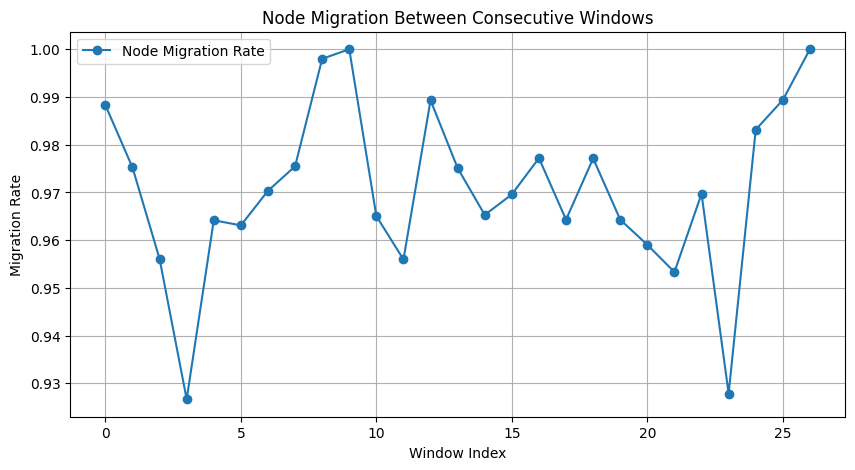

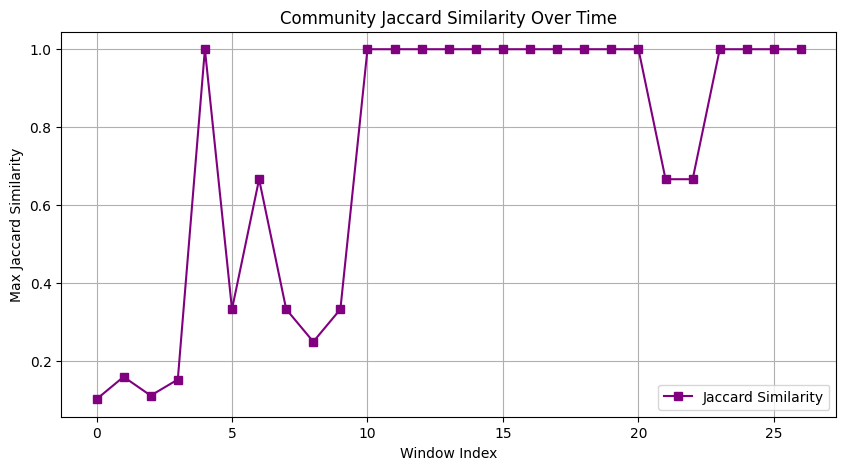

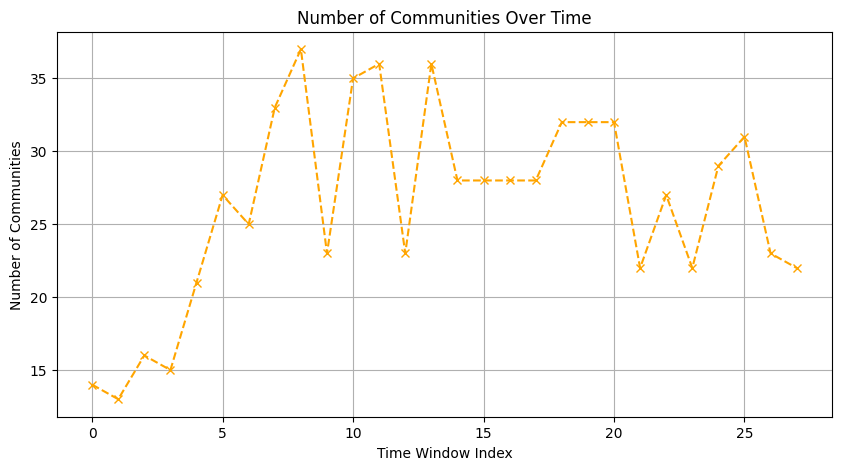

In [33]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from cdlib import algorithms, TemporalClustering
from sklearn.metrics import jaccard_score
from collections import defaultdict
import os

# --- Helper to convert communities to node → community_id mapping ---
def node_to_community_map(communities):
    mapping = {}
    for cid, community in enumerate(communities):
        for node in community:
            mapping[node] = cid
    return mapping

# --- Compute node migration rates ---
def compute_node_migration(clusterings):
    migrations = []
    for i in range(len(clusterings) - 1):
        c1_map = node_to_community_map(clusterings[i].communities)
        c2_map = node_to_community_map(clusterings[i + 1].communities)

        nodes = set(c1_map.keys()).union(c2_map.keys())
        changed = sum(1 for n in nodes if c1_map.get(n) != c2_map.get(n))
        rate = changed / len(nodes) if nodes else 0
        migrations.append(rate)
    return migrations

# --- Compute Jaccard similarities between communities across windows ---
def compute_jaccard_similarity(clusterings):
    similarities = []
    for i in range(len(clusterings) - 1):
        comms1 = [set(c) for c in clusterings[i].communities]
        comms2 = [set(c) for c in clusterings[i + 1].communities]

        best_sim = 0
        for c1 in comms1:
            for c2 in comms2:
                intersection = len(c1 & c2)
                union = len(c1 | c2)
                if union > 0:
                    sim = intersection / union
                    best_sim = max(best_sim, sim)
        similarities.append(best_sim)
    return similarities


# --- Load and preprocess UCI private messages dataset ---
df = pd.read_csv('../data/CollegeMsg.txt', sep=' ', names=['source', 'target', 'timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')  # Convert UNIX timestamp to datetime

# --- Define time window parameters ---
window_size = pd.Timedelta(days=7)  # You can adjust the window size as needed
start_time = df['timestamp'].min()
end_time = df['timestamp'].max()

time_windows = []
current_time = start_time
while current_time < end_time:
    time_windows.append((current_time, current_time + window_size))
    current_time += window_size

# --- Community detection per window ---
tc = TemporalClustering()
graphs = []

for idx, (start, end) in enumerate(time_windows):
    window_df = df[(df['timestamp'] >= start) & (df['timestamp'] < end)]
    if window_df.empty:
        continue

    G = nx.from_pandas_edgelist(window_df, 'source', 'target', create_using=nx.DiGraph())  # Directed graph
    undirected_G = G.to_undirected()  # Convert to undirected graph for community detection
    coms = algorithms.louvain(undirected_G)
    
    graphs.append(G)
    tc.add_clustering(coms, start.timestamp())  # Add the community structure for each time window


# --- Compute node migration rates ---
def compute_node_migration(clusterings):
    migrations = []
    for i in range(len(clusterings) - 1):
        c1 = node_to_community_map(clusterings[i].communities)
        c2 = node_to_community_map(clusterings[i + 1].communities)
        
        nodes = set(c1.keys()).union(c2.keys())
        changed = sum(1 for n in nodes if c1.get(n) != c2.get(n))
        rate = changed / len(nodes) if nodes else 0
        migrations.append(rate)
    return migrations

# --- Compute community Jaccard similarities between windows ---
def compute_jaccard_similarity(clusterings):
    similarities = []
    for i in range(len(clusterings) - 1):
        comms1 = [set(c) for c in clusterings[i].communities]
        comms2 = [set(c) for c in clusterings[i+1].communities]

        best_sim = 0
        for c1 in comms1:
            for c2 in comms2:
                intersection = len(c1 & c2)
                union = len(c1 | c2)
                if union > 0:
                    sim = intersection / union
                    if sim > best_sim:
                        best_sim = sim
        similarities.append(best_sim)
    return similarities

# --- Plot metrics ---
if len(tc.clusterings) >= 2:
    migration_rates = compute_node_migration(tc.clusterings)
    jaccard_similarities = compute_jaccard_similarity(tc.clusterings)

    # Plot node migration
    plt.figure(figsize=(10, 5))
    plt.plot(migration_rates, marker='o', label='Node Migration Rate')
    plt.title('Node Migration Between Consecutive Windows')
    plt.xlabel('Window Index')
    plt.ylabel('Migration Rate')
    plt.grid(True)
    plt.legend()
    plt.savefig('node_migration_uci_private_messages.png')
    plt.show()

    # Plot Jaccard similarity
    plt.figure(figsize=(10, 5))
    plt.plot(jaccard_similarities, marker='s', color='purple', label='Jaccard Similarity')
    plt.title('Community Jaccard Similarity Over Time')
    plt.xlabel('Window Index')
    plt.ylabel('Max Jaccard Similarity')
    plt.grid(True)
    plt.legend()
    plt.savefig('jaccard_similarity_uci_private_messages.png')
    plt.show()
else:
    print("Not enough clusterings to evaluate temporal metrics.")

# --- Plot number of communities over time ---
num_communities = [len(clustering.communities) for clustering in tc.clusterings.values()]

plt.figure(figsize=(10, 5))
plt.plot(num_communities, marker='x', linestyle='--', color='orange')
plt.title('Number of Communities Over Time')
plt.xlabel('Time Window Index')
plt.ylabel('Number of Communities')
plt.grid(True)
plt.savefig('num_communities_uci_private_messages.png')
plt.show()
